In [1]:
import os
os.chdir("..")
!pwd
!pyenv version
%load_ext autoreload
%autoreload 2

/Users/loicmorel/code/projetcs/crypto_assistant
crypto_assistant (set by PYENV_VERSION environment variable)


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyts.image import GramianAngularField
from mpl_toolkits.axes_grid1 import ImageGrid
from datetime import datetime
from datetime import timezone
from app.indicators import find_swings
from app.indicators import classify_swings

# Generate Gramian Angular Fields images from OHLC datas

In [410]:
from app.data_mgt.datamgt import ohlcv_from_csv_to_df
file = 'data/ohlcv_ETHUSDT_1h_from_1502942400000_to_1651507200000.csv'
data = ohlcv_from_csv_to_df(file)
data

,o_ts,Open,High,Low,Close,Volume,c_ts,o_date
0,2017-08-17 04:00:00,301.13,302.57,298.00,301.61,125.66877,2017-08-17 04:59:59.999000064,17395.166667
1,2017-08-17 05:00:00,301.61,303.28,300.00,303.10,377.67246,2017-08-17 05:59:59.999000064,17395.208333
2,2017-08-17 06:00:00,302.40,304.44,301.90,302.68,303.86672,2017-08-17 06:59:59.999000064,17395.250000
3,2017-08-17 07:00:00,302.68,307.96,302.60,307.96,754.74510,2017-08-17 07:59:59.999000064,17395.291667
4,2017-08-17 08:00:00,307.95,309.97,307.00,308.62,150.75029,2017-08-17 08:59:59.999000064,17395.333333
...,...,...,...,...,...,...,...,...
41138,2022-05-02 12:00:00,2795.05,2811.47,2789.28,2795.57,17163.77510,2022-05-02 12:59:59.999000064,19114.500000
41139,2022-05-02 13:00:00,2795.54,2845.10,2778.78,2829.25,64991.93710,2022-05-02 13:59:59.999000064,19114.541667
41140,2022-05-02 14:00:00,2829.25,2852.53,2805.23,2828.00,46120.43640,2022-05-02 14:59:59.999000064,19114.583333
41141,2022-05-02 15:00:00,2827.99,2835.49,2814.10,2827.68,24617.00230,2022-05-02 15:59:59.999000064,19114.625000


In [4]:
from matplotlib.pyplot import imshow

def slice_df_from_date(data_df, date_str, freq, depth):
    # groupby 1h base on o_ts
    data_ = data_df.groupby(pd.Grouper(key='o_ts', freq=freq)).mean().reset_index()
    # nb depth last data from date
    index = idx_from_date(data_, date_str)
    data__ = data_[index-depth+1:index+1]
    return data__

def idx_from_date(data, date):
    dt = datetime.strptime(date, "%Y-%m-%d %H:%M:%S")
    for index in range(0, len(data)):
        if (index+1) >= len(data) and data['o_ts'][index] >= dt:
            return index
        elif (index+1) >= len(data):
            return -1
        elif data['o_ts'][index] <= dt and data['o_ts'][index+1] > dt:
            return index
    return -1

def generate_gaf_image_from_df(data):
    gadf = GramianAngularField(method='difference', image_size=data.shape[0])
    img = gadf.fit_transform(pd.DataFrame(data).T)[0]
    return img

def generate_gaf_matrix(list_df):
    image_matrix: tuple =(2, 2)
    fig = plt.figure(figsize=[img * 4 for img in image_matrix])
    grid = ImageGrid(fig,
                     111,
                     axes_pad=0,
                     nrows_ncols=image_matrix,
                     share_all=True,
                     )

    im1 = generate_gaf_image_from_df(list_df[0])
    im2 = generate_gaf_image_from_df(list_df[1])
    im3 = generate_gaf_image_from_df(list_df[2])
    im4 = generate_gaf_image_from_df(list_df[3])

    for ax, im in zip(grid, [im1, im2, im3, im4]):
        # Iterating over the grid returns the Axes.
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(im, cmap='rainbow', origin='lower')
        
def plot_x_y__vs__gaf_image(x, y):
    fig = plt.figure(figsize=(14,5), constrained_layout=True)
    gs = fig.add_gridspec(1, 2)

    f_ax1 = fig.add_subplot(gs[0, 0])
    f_ax2 = fig.add_subplot(gs[0, 1])

    f_ax1.plot(x, y)
    f_ax2.imshow(generate_gaf_image_from_df(y), cmap='rainbow', origin='lower')

## Play with known series

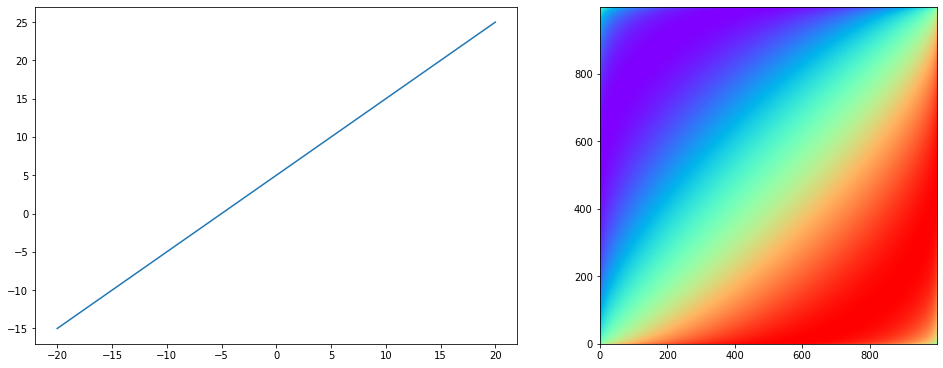

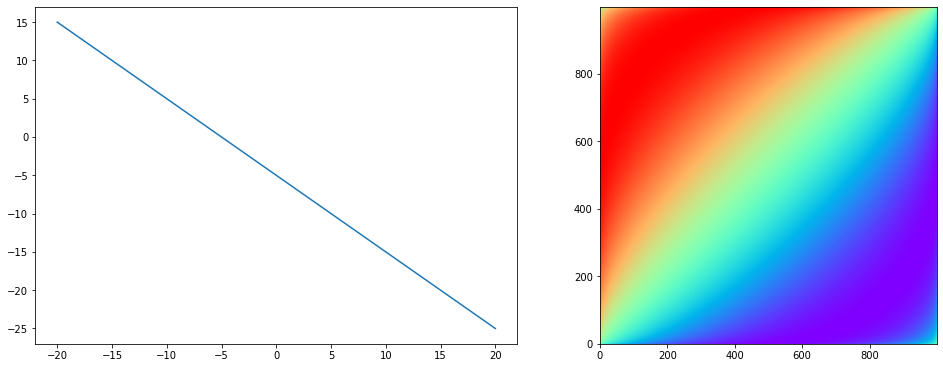

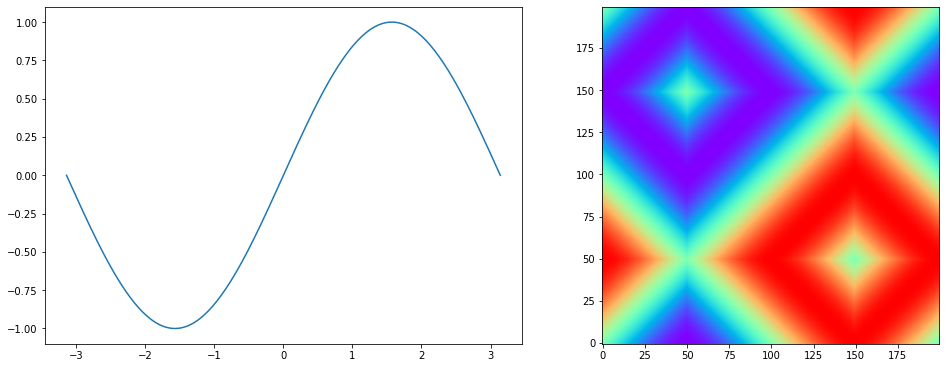

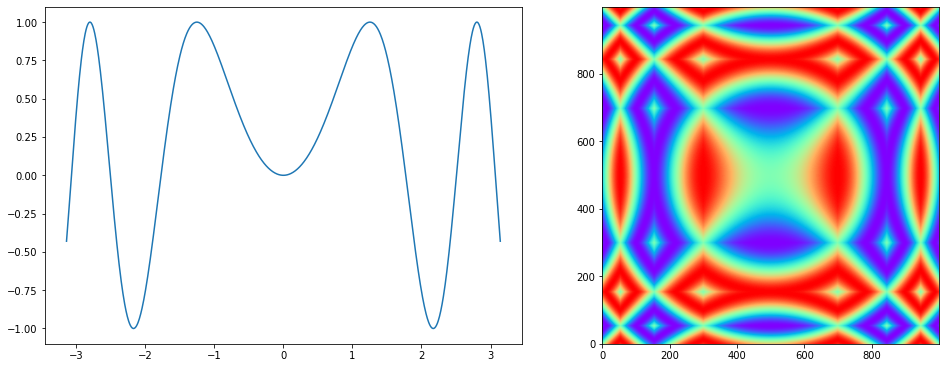

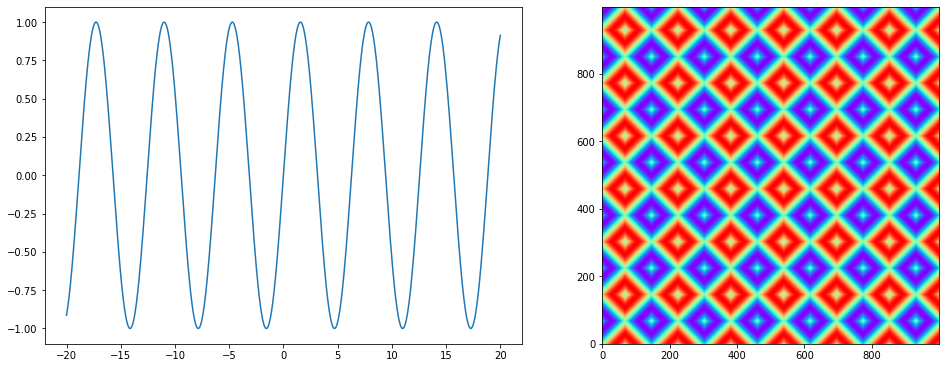

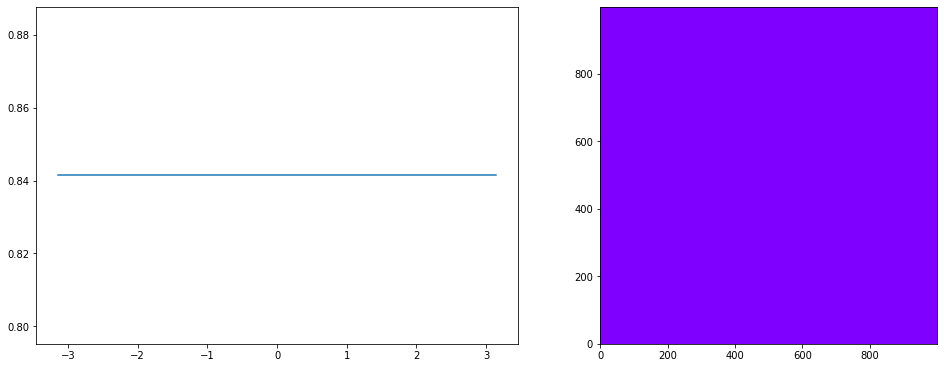

In [5]:
x = np.linspace(-20, 20, 1000)
y = x+5
plot_x_y__vs__gaf_image(x, y)

x = np.linspace(-20, 20, 1000)
y = -x-5
plot_x_y__vs__gaf_image(x, y)

x = np.linspace(-np.pi, np.pi, 200)
y = np.sin(x)
plot_x_y__vs__gaf_image(x, y)

x = np.linspace(-np.pi, np.pi, 1000)
y = np.sin(x*x)
plot_x_y__vs__gaf_image(x, y)

x = np.linspace(-20, 20, 1000)
y = np.sin(x)
plot_x_y__vs__gaf_image(x, y)

x = np.linspace(-np.pi, np.pi, 1000)
y = np.sin(x/x)
plot_x_y__vs__gaf_image(x, y)

## Integrate time series from dataframe

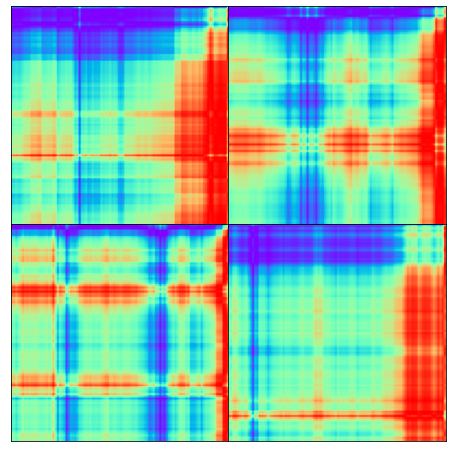

In [6]:
# list_df = [slice_df_from_date(data, '2017-10-05 23:00:00', '1h', 100),
#            slice_df_from_date(data, '2017-10-05 22:00:00', '2h', 100),
#            slice_df_from_date(data, '2017-10-05 20:00:00', '4h', 100), 
#            slice_df_from_date(data, '2017-10-05 00:00:00', '1d', 20)]

date = '2017-12-12 23:12:00'
depth = 100
list_df = [slice_df_from_date(data, date, '1h', depth)['Close'],
           slice_df_from_date(data, date, '2h', depth)['Close'],
           slice_df_from_date(data, date, '4h', depth)['Close'], 
           slice_df_from_date(data, date, '1d', depth)['Close']]
generate_gaf_matrix(list_df)

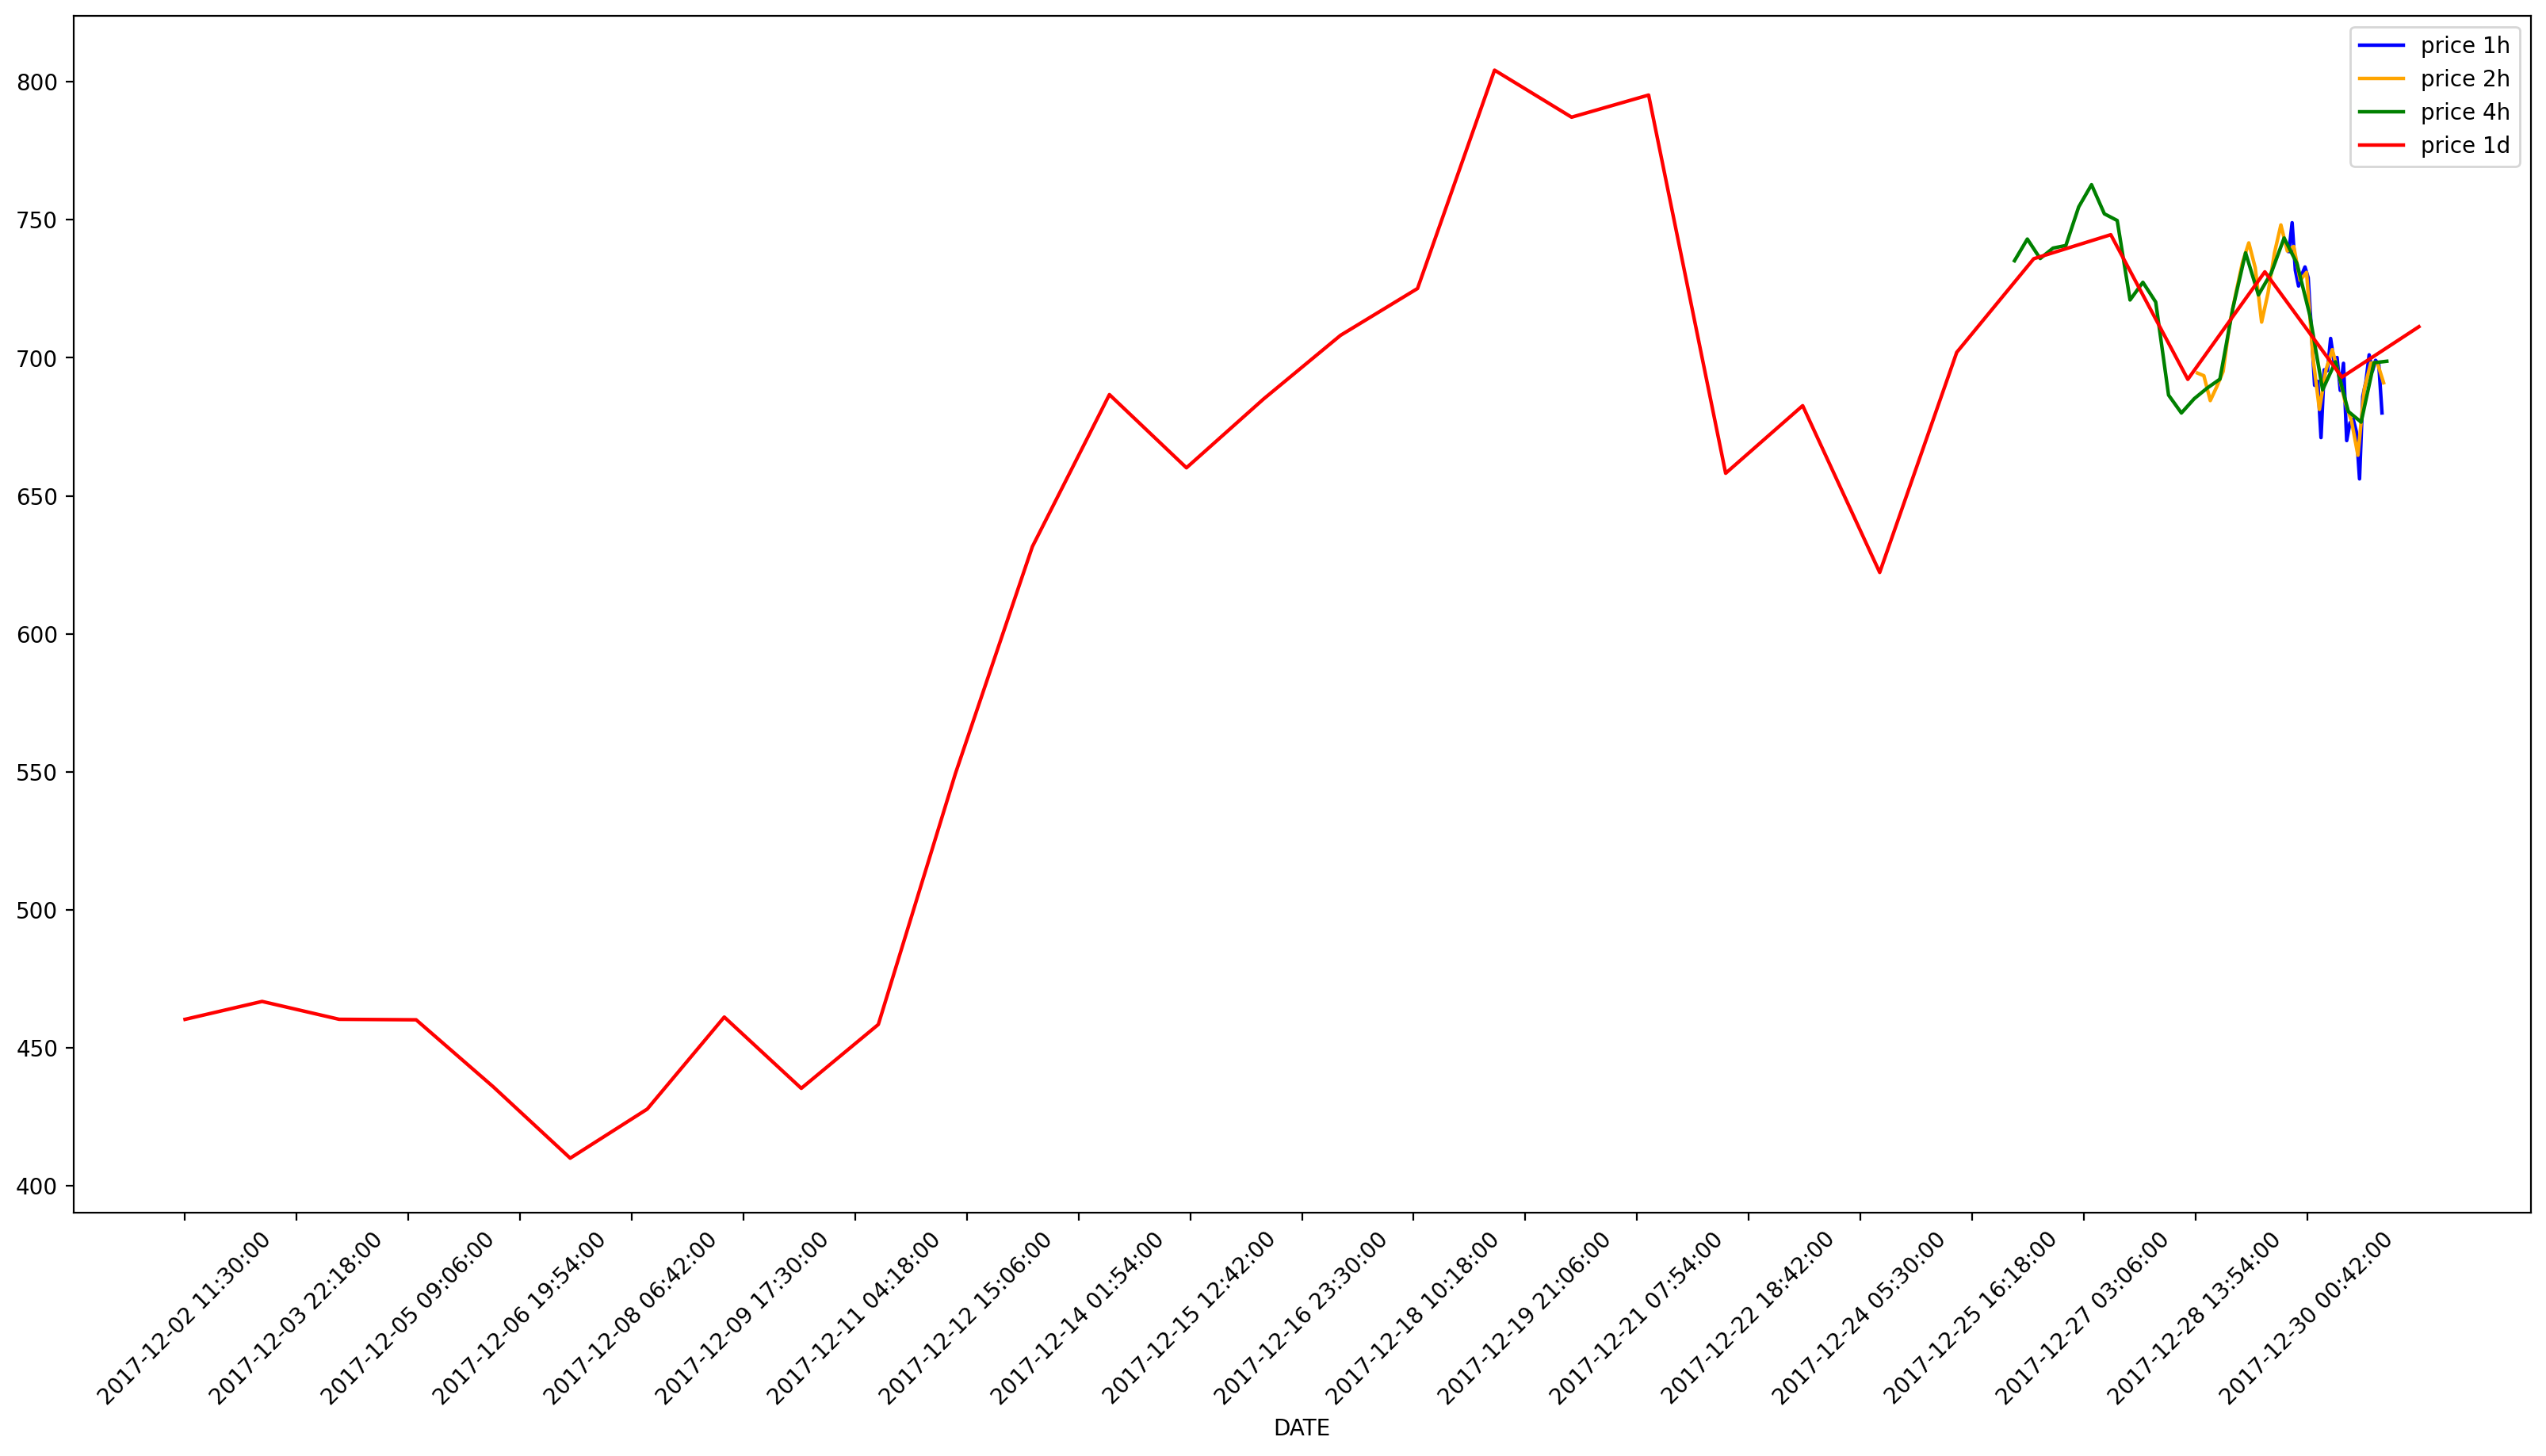

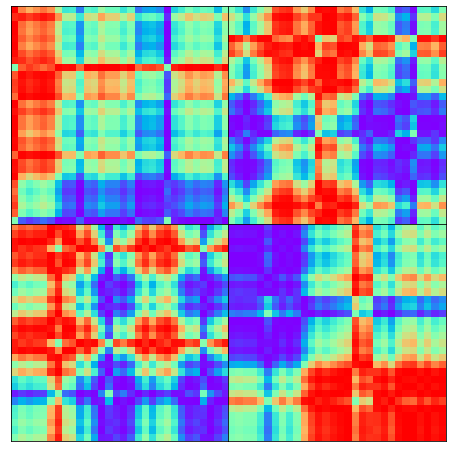

In [7]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.dates as mdates
from datetime import datetime

date = '2017-12-31 00:00:00'
depth = 30

data_1h = slice_df_from_date(data, date, '1h', depth)
data_2h = slice_df_from_date(data, date, '2h', depth)
data_4h = slice_df_from_date(data, date, '4h', depth)
data_1d = slice_df_from_date(data, date, '1d', depth)

fig_size = 200
fig = plt.figure(figsize=(20, 10), dpi=fig_size)

gs = gridspec.GridSpec(8, 1, wspace=0.00, hspace=0.00)  # 7x1 grid
ax = fig.add_subplot(gs[0:, 0])  # first row

data_1h.plot(lw=1.6, x='o_date', y='Open', color='blue', kind='line', ax=ax, label='price 1h')
data_2h.plot(lw=1.6, x='o_date', y='Open', color='orange', kind='line', ax=ax, label='price 2h')
data_4h.plot(lw=1.6, x='o_date', y='Open', color='green', kind='line', ax=ax, label='price 4h')
data_1d.plot(lw=1.6, x='o_date', y='Open', color='red', kind='line', ax=ax, label='price 1d')
# data_p.plot(lw=1.6, x='o_date', y='Close', color='green', kind='line', ax=ax, label='Close price')
g_time = data_1d["o_date"].iloc[-1] - data_1d["o_date"].iloc[0]
date_space = g_time / fig_size * 10
ax.xaxis.set_ticks(np.arange(data_1d["o_date"].iloc[0], data_1d["o_date"].iloc[-1], date_space))

ax.set_xlabel('DATE', fontsize=10)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M:%S'))
ax.tick_params(axis='x', labelrotation=45)

list_df = [data_1h['Close'],
           data_2h['Close'],
           data_4h['Close'], 
           data_1d['Close']]
generate_gaf_matrix(list_df)

# Encoding dataset to image with target naming

In [382]:
# add target to the dataframe
data_ = find_swings(data)
data__ = classify_swings(data_)
# concat databases
data_c = pd.concat([data, data__], axis="columns")
data_c.drop(columns=[
    'CSLS',
    'Support',
    'Resistance',
    'Strong_lows',
    'Strong_highs',
    'FSL',
    'FSH',
    'Highs',
    'Lows',
    'Last',
    'Trend',
    'o_date'
    ], inplace=True)

# data_c = data_c[0:1500]
# data_c.tail(50)

# generate img 2D array + params (freq, deepth) from dataframe and tag with target value
encode_gaf_params = {
    'depth': 40,
    'freq': ['1h', '2h', '4h', '1d'],
    'focus': 'Close',
    'target': ['LL', 'HH']
}

data_c['gaf'] = data_c[::-1].apply(lambda r: generate_gaf_images_from_ohlc(data_c, encode_gaf_params, r.name+1), axis=1)
data_c = data_c.dropna().reset_index().drop(columns='index')
data_c

,o_ts,Open,High,Low,Close,Volume,c_ts,LL,HL,HH,LH,gaf
0,2017-09-25 14:00:00,288.69,297.12,288.01,295.72,423.58549,2017-09-25 14:59:59.999000064,True,False,False,False,"{'deep': 40, 'freq': ['1h', '2h', '4h', '1d'],..."
1,2017-09-25 18:00:00,292.69,294.18,291.03,293.53,250.43062,2017-09-25 18:59:59.999000064,False,False,True,False,"{'deep': 40, 'freq': ['1h', '2h', '4h', '1d'],..."
2,2017-09-26 08:00:00,293.00,293.90,289.56,292.06,182.65086,2017-09-26 08:59:59.999000064,True,False,False,False,"{'deep': 40, 'freq': ['1h', '2h', '4h', '1d'],..."
3,2017-09-26 22:00:00,289.45,290.99,287.87,289.45,192.03753,2017-09-26 22:59:59.999000064,True,False,False,False,"{'deep': 40, 'freq': ['1h', '2h', '4h', '1d'],..."
4,2017-09-27 04:00:00,291.02,292.88,291.01,291.54,232.29645,2017-09-27 04:59:59.999000064,True,False,False,False,"{'deep': 40, 'freq': ['1h', '2h', '4h', '1d'],..."
...,...,...,...,...,...,...,...,...,...,...,...,...
4025,2022-04-30 20:00:00,2806.74,2807.86,2786.01,2790.03,9233.40660,2022-04-30 20:59:59.999000064,True,False,False,False,"{'deep': 40, 'freq': ['1h', '2h', '4h', '1d'],..."
4026,2022-05-01 02:00:00,2770.26,2780.62,2754.76,2758.16,16032.09270,2022-05-01 02:59:59.999000064,True,False,False,False,"{'deep': 40, 'freq': ['1h', '2h', '4h', '1d'],..."
4027,2022-05-01 19:00:00,2773.23,2777.62,2755.10,2765.39,20779.74640,2022-05-01 19:59:59.999000064,False,False,True,False,"{'deep': 40, 'freq': ['1h', '2h', '4h', '1d'],..."
4028,2022-05-02 08:00:00,2845.26,2855.86,2832.18,2838.83,13337.21820,2022-05-02 08:59:59.999000064,False,False,True,False,"{'deep': 40, 'freq': ['1h', '2h', '4h', '1d'],..."


In [408]:
def generate_gaf(data):
    gadf = GramianAngularField(method='difference', image_size=data.shape[0])
    img = gadf.fit_transform(pd.DataFrame(data).T)[0]
    return img

def generate_gaf_images_from_ohlc(data, params, idx):
    ## identify target
    target = False
    for t in params['target']:
        if data[:idx][t].iloc[-1]:
            target = t
    if not target:
        return np.nan
#     print('found target:', target, data[:idx]['LL'].iloc[-1], data[:idx]['o_ts'].iloc[-1])

    ## slicing data from the bottom of the df (reverse the time) 
    ## to the top from the index provided by the lambda function
    data_slice = data[:idx][['o_ts', params['focus']]]
    img = []
    ret = params.copy()
    ret['target'] = target
    
    ## for 4x frequency to compose the gaf matrix
    for freq in params['freq']:
        data_ = data_slice.groupby(pd.Grouper(key='o_ts', freq=freq)).mean().reset_index()
        data_ = data_.dropna()
        data__ = data_[::-1].reset_index().drop(columns='index')
        data___ = data__[:params['depth']]
#         print('ferq:', freq, 'start time:', data___['o_ts'].iloc[0], 'end time:', data___['o_ts'].iloc[-1], data___.shape)
        if data___.shape[0] < params['depth']:
#                 print('not enough data, shape vs depth:', data___.shape[0], params['depth'])
            return np.nan
        ret[f'start_time_{freq}'] = data___['o_ts'].iloc[0]
        ret[f'end_time_{freq}'] = data___['o_ts'].iloc[-1]
        img.append(generate_gaf(data___[params['focus']]))
    ret['img'] = np.array(img)
    return (ret)

def plot_gaf_image_matrix(img_np, target):
    image_matrix: tuple =(2, 2)
    fig = plt.figure(figsize=[img * 4 for img in image_matrix])
    plt.title(f'Target: {target}')
    grid = ImageGrid(fig,
                     111,
                     axes_pad=0,
                     nrows_ncols=image_matrix,
                     share_all=True,
                     )

    for ax, im in zip(grid, img_np):
        # Iterating over the grid returns the Axes.
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(im, cmap='rainbow', origin='lower')


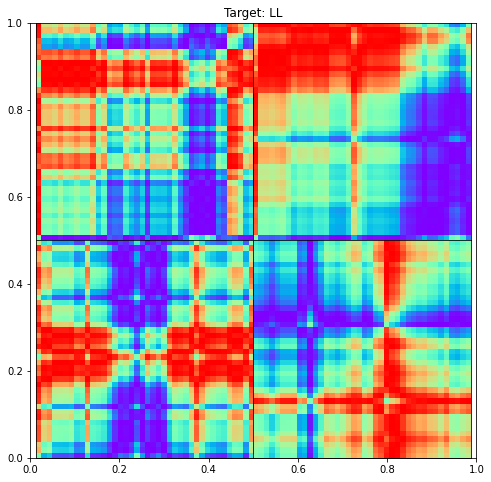

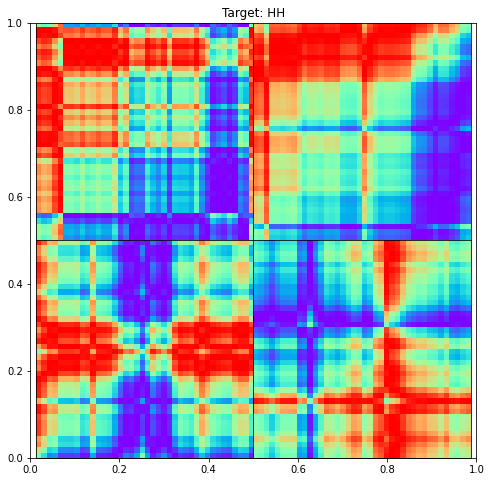

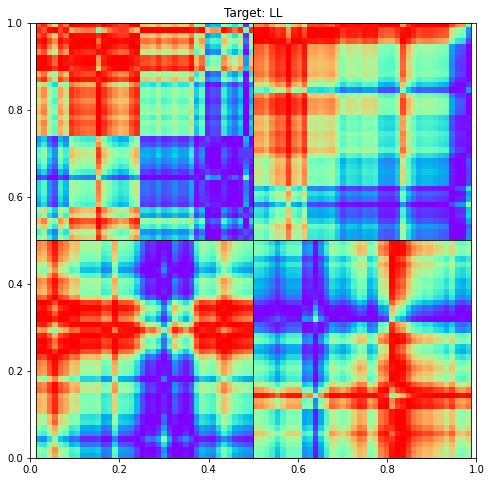

In [409]:
# print gaf images in the df
images = data_c.gaf[0:3]
for img in images:
    plot_gaf_image_matrix(img['img'], img['target'])


In [373]:
data_c.dtypes

o_ts      datetime64[ns]
Open             float64
High             float64
Low              float64
Close            float64
Volume           float64
c_ts      datetime64[ns]
LL                  bool
HL                  bool
HH                  bool
LH                  bool
gaf               object
dtype: object

In [375]:
data_c.gaf.iloc[-1]

{'deep': 40,
 'freq': ['1h', '2h', '4h', '1d'],
 'focus': 'Close',
 'target': 'LL',
 'start_time_1h': Timestamp('2022-05-02 14:00:00'),
 'end_time_1h': Timestamp('2022-04-30 23:00:00'),
 'start_time_2h': Timestamp('2022-05-02 14:00:00'),
 'end_time_2h': Timestamp('2022-04-29 08:00:00'),
 'start_time_4h': Timestamp('2022-05-02 12:00:00'),
 'end_time_4h': Timestamp('2022-04-26 00:00:00'),
 'start_time_1d': Timestamp('2022-05-02 00:00:00'),
 'end_time_1d': Timestamp('2022-03-24 00:00:00'),
 'img': array([[[ 0.        ,  0.02166506, -0.4849663 , ..., -0.77723275,
          -0.99983887, -0.86271932],
         [-0.02166506,  0.        , -0.50379928, ..., -0.79068226,
          -0.9999931 , -0.85156117],
         [ 0.4849663 ,  0.50379928,  0.        , ..., -0.37456837,
          -0.86568622, -0.99971563],
         ...,
         [ 0.77723275,  0.79068226,  0.37456837, ...,  0.        ,
          -0.61515959, -0.93586784],
         [ 0.99983887,  0.9999931 ,  0.86568622, ...,  0.61515959,
    

In [380]:
data_c.gaf[0]['img'].shape

(4, 40, 40)

In [379]:
index = -1
print(data_c.iloc[index].o_ts)
data_c.iloc[index].gaf['start_time_1h']

2022-05-02 14:00:00


Timestamp('2022-05-02 14:00:00')

2017-09-25 14:00:00
2017-09-25 14:00:00 2017-09-23 23:00:00
2017-09-25 14:00:00 2017-09-22 08:00:00
2017-09-25 12:00:00 2017-09-19 00:00:00
2017-09-25 00:00:00 2017-08-17 00:00:00


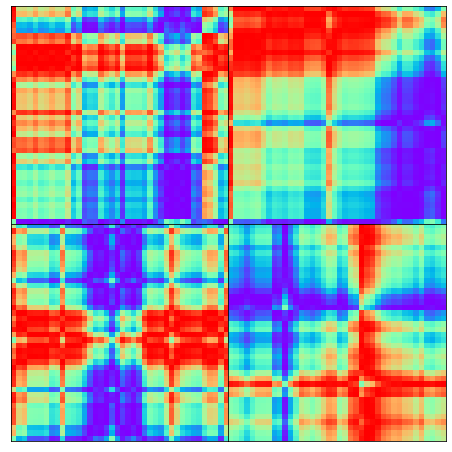

In [378]:
index = 0
generate_gaf_image_matrix(data_c.gaf[index]['img'])
print(data_c.o_ts[index])
print(data_c.iloc[index].gaf['start_time_1h'], data_c.iloc[index].gaf['end_time_1h'])
print(data_c.iloc[index].gaf['start_time_2h'], data_c.iloc[index].gaf['end_time_2h'])
print(data_c.iloc[index].gaf['start_time_4h'], data_c.iloc[index].gaf['end_time_4h'])
print(data_c.iloc[index].gaf['start_time_1d'], data_c.iloc[index].gaf['end_time_1d'])

In [105]:
data_c[4:5].index
# data_c[0:5]

RangeIndex(start=41138, stop=41137, step=-1)

In [19]:
def gen_gaf(data, row, params):
    print('init:', row.index.start)
    data_ = data[row.index.start:10]
    print(data_)

#     print(data.shape, 'index:', row.index.start)
#     for freq in params['freq']:
#         data_ = data[row.index.start:]
#         data__ = data_.groupby(pd.Grouper(key='o_ts', freq=freq)).mean().reset_index()
#         data___ = data__[:params['depth']]
#         print(data___)
# #     sl1 = slice_df_from_ts(data, row['o_ts'], '1h', params['depth'])[params['focus']]
#     return {'params':params, 'img':555}

encode_gaf_params = {
    'depth': 50,
    'freq': ['1h', '2h', '4h', '1d'],
    'focus': 'Close',
    'target': ['LL', 'HH']
}
gen_gaf(data_c, data_c[0:1], encode_gaf_params)

def slice_df_from_ts(data_df, date_str, freq, depth):
    # groupby 1h base on o_ts
    data_ = data_df.groupby(pd.Grouper(key='o_ts', freq=freq)).mean().reset_index()
    # nb depth last data from date
    index = idx_from_date(data_, date_str)
    data__ = data_[index-depth+1:index+1]
    return data__


def slice_df_from_date(data_df, date_str, freq, depth):
    # groupby 1h base on o_ts
    data_ = data_df.groupby(pd.Grouper(key='o_ts', freq=freq)).mean().reset_index()
    # nb depth last data from date
    index = idx_from_date(data_, date_str)
    data__ = data_[index-depth+1:index+1]
    return data__

def idx_from_date(data, date):
    dt = datetime.strptime(date, "%Y-%m-%d %H:%M:%S")
    for index in range(0, len(data)):
        if (index+1) >= len(data) and data['o_ts'][index] >= dt:
            return index
        elif (index+1) >= len(data):
            return -1
        elif data['o_ts'][index] <= dt and data['o_ts'][index+1] > dt:
            return index
    return -1

init: 0
                 o_ts    Open    High     Low   Close     Volume  \
0 2017-08-17 04:00:00  301.13  302.57  298.00  301.61  125.66877   
1 2017-08-17 05:00:00  301.61  303.28  300.00  303.10  377.67246   
2 2017-08-17 06:00:00  302.40  304.44  301.90  302.68  303.86672   
3 2017-08-17 07:00:00  302.68  307.96  302.60  307.96  754.74510   
4 2017-08-17 08:00:00  307.95  309.97  307.00  308.62  150.75029   
5 2017-08-17 09:00:00  308.62  312.00  308.62  310.00  469.27879   
6 2017-08-17 10:00:00  310.00  310.97  308.54  309.30  284.39140   
7 2017-08-17 11:00:00  308.30  310.68  307.78  308.95  273.29040   
8 2017-08-17 12:00:00  308.95  310.51  307.98  308.62  401.79278   
9 2017-08-17 13:00:00  308.62  309.72  307.77  309.40  310.58042   

                           c_ts     LL     HL     HH     LH  
0 2017-08-17 04:59:59.999000064  False  False  False  False  
1 2017-08-17 05:59:59.999000064  False  False  False  False  
2 2017-08-17 06:59:59.999000064  False  False  False  Fal

In [84]:
# generate img 2D array + params (freq, deepth) from dataframe and tag with target value
encode_gaf_params = {
    'depth': 50,
    'freq': ['1h', '2h', '4h', '1d'],
    'focus': 'Close',
    'target': ['LL', 'HH']
}
data_c['gaf'][0:5] = data_c[0:5].apply(lambda r: gen_gaf(data_c, r, encode_gaf_params), axis=1)
data_c

# for idx in range(0, 5):
#     print(data_c['gaf'][idx].get('image'))
# date = '2017-12-12 23:12:00'
# depth = 100
# list_df = [slice_df_from_date(data, date, '1h', depth)['Close'],
#            slice_df_from_date(data, date, '2h', depth)['Close'],
#            slice_df_from_date(data, date, '4h', depth)['Close'], 
#            slice_df_from_date(data, date, '1d', depth)['Close']]
# generate_gaf_matrix(list_df)

(41143, 10) o_ts      2022-05-02 16:00:00
Open                  2827.68
High                  2833.66
Low                    2816.0
Close                 2832.76
Volume             11106.6112
LL                      False
HL                      False
HH                      False
LH                      False
Name: 41142, dtype: object
(41143, 10) o_ts      2022-05-02 15:00:00
Open                  2827.99
High                  2835.49
Low                    2814.1
Close                 2827.68
Volume             24617.0023
LL                      False
HL                      False
HH                      False
LH                      False
Name: 41141, dtype: object
(41143, 10) o_ts      2022-05-02 14:00:00
Open                  2829.25
High                  2852.53
Low                   2805.23
Close                  2828.0
Volume             46120.4364
LL                       True
HL                      False
HH                      False
LH                      False
Name: 4114

KeyError: 'gaf'

In [ ]:
# generate images + send to bucket

========PREPROCESS REPORT========:
Total Data Points: 84
Total Images Created: 33
Total LONG positions: 19
Total SHORT positions: 14
1h 2h 4h 1d


/var/folders/63/jtw8zvs150d2gcdq9t06pn_m0000gn/T/ipykernel_81115/3539265561.py:107: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=[img * 4 for img in image_matrix])


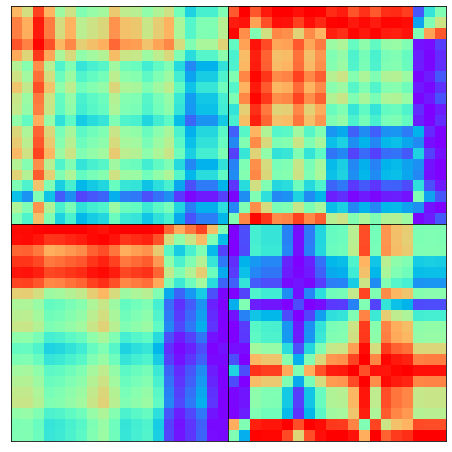

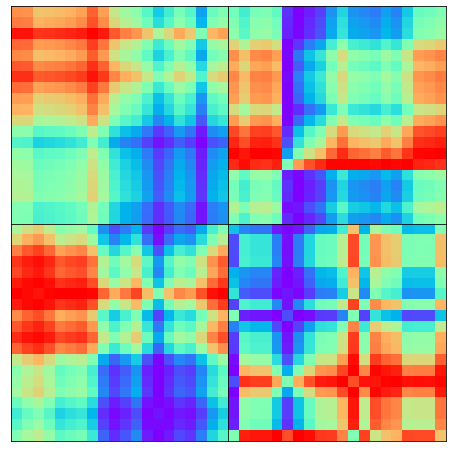

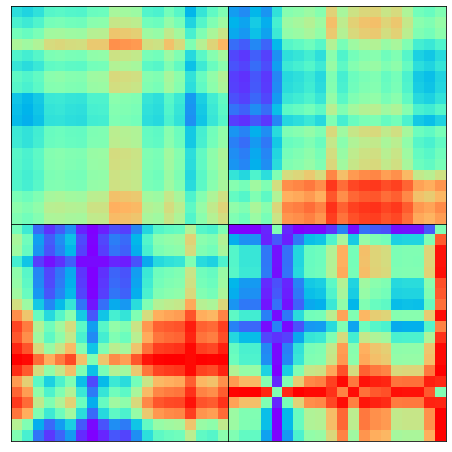

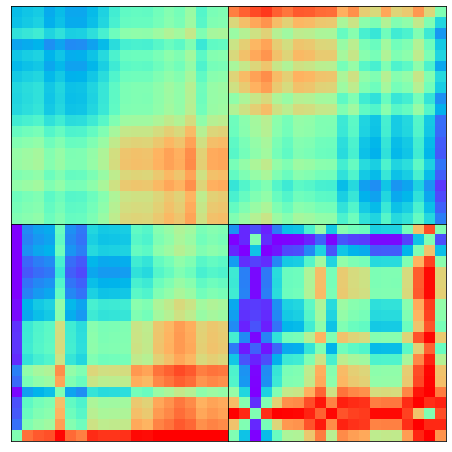

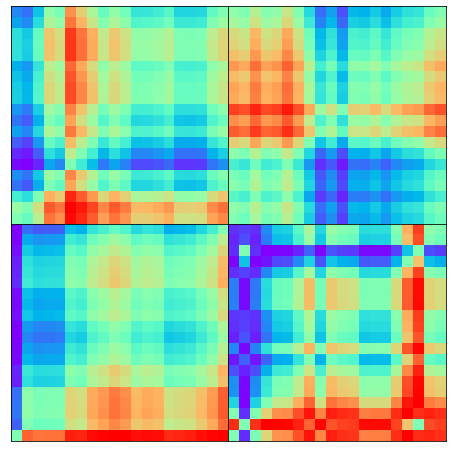

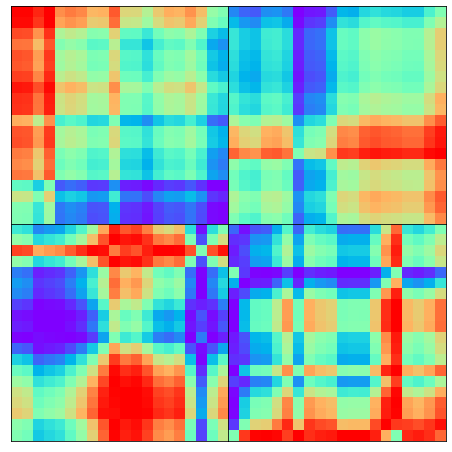

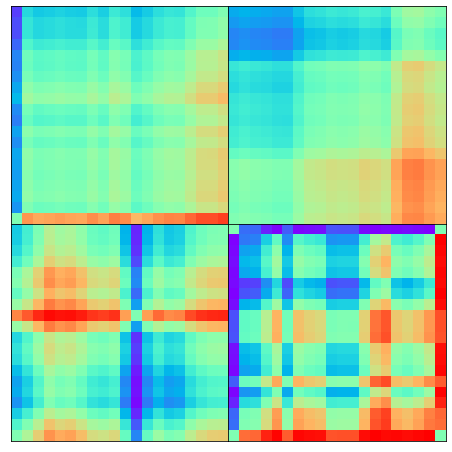

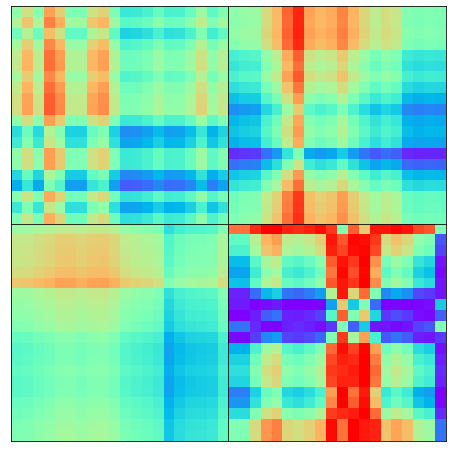

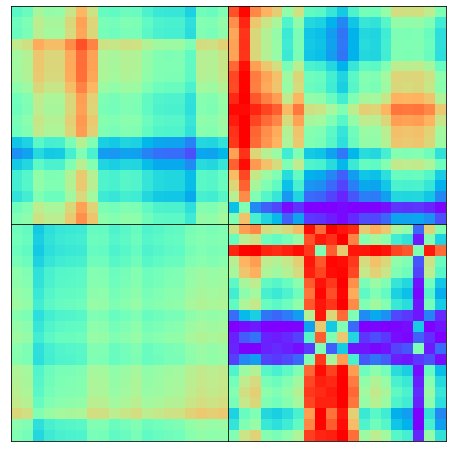

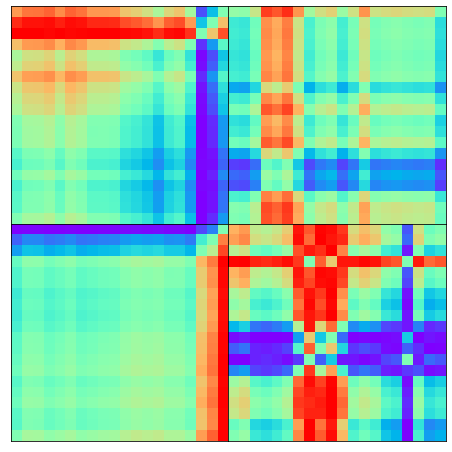

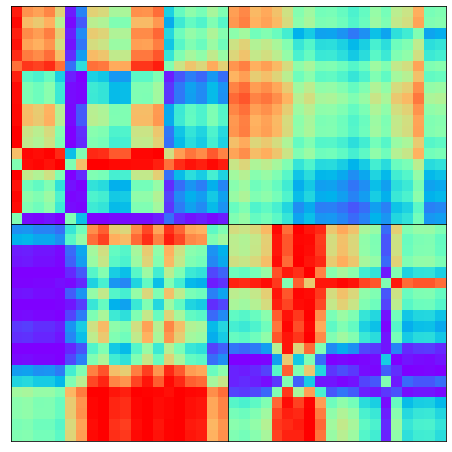

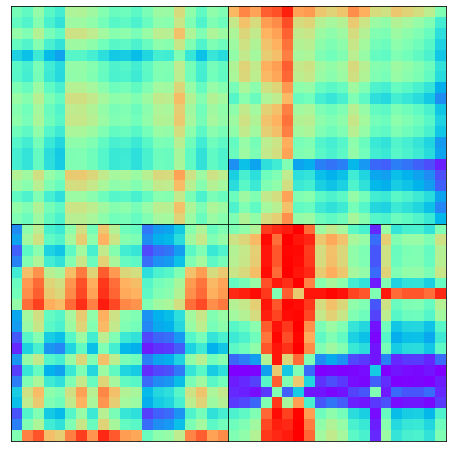

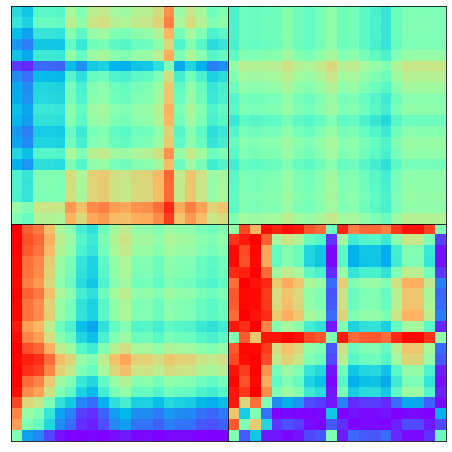

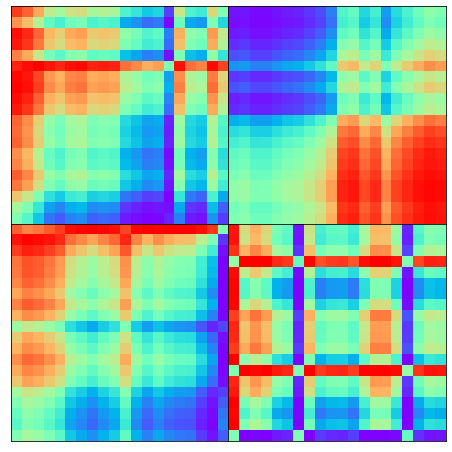

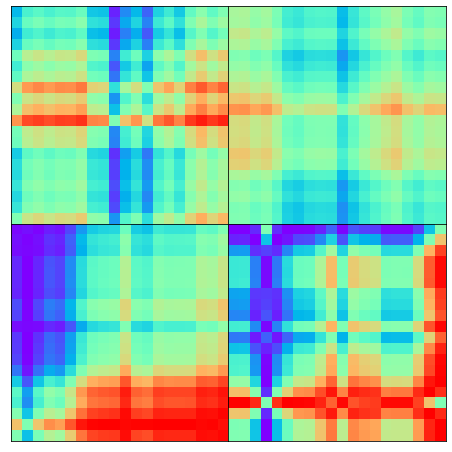

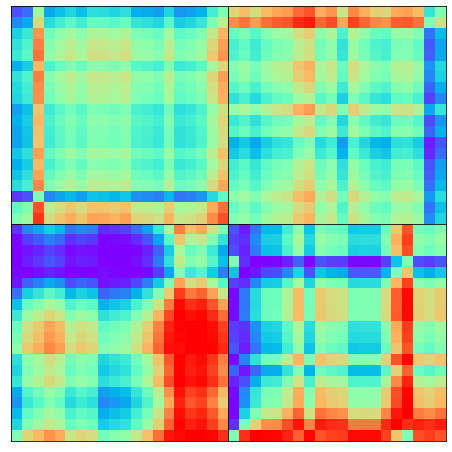

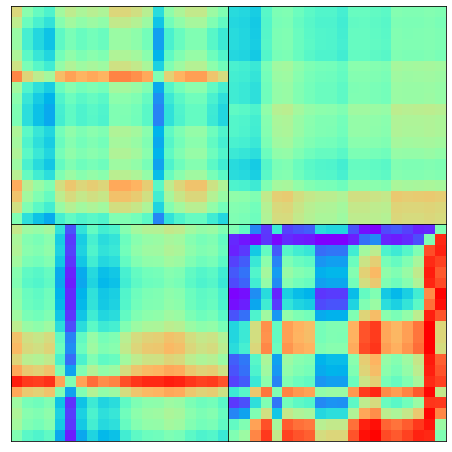

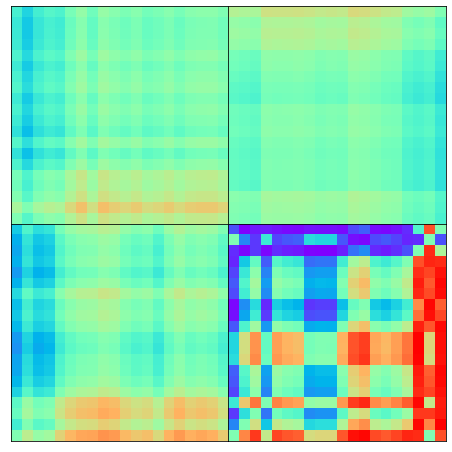

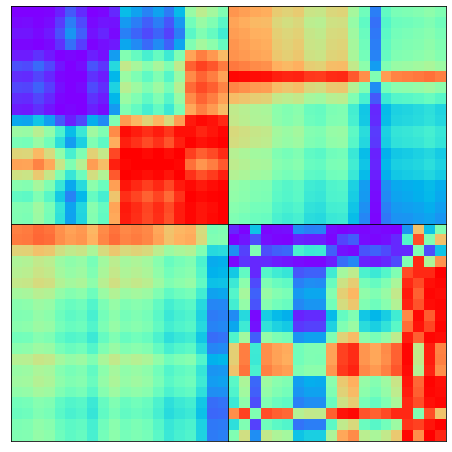

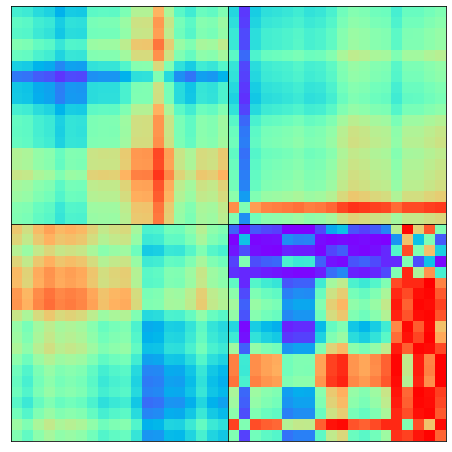

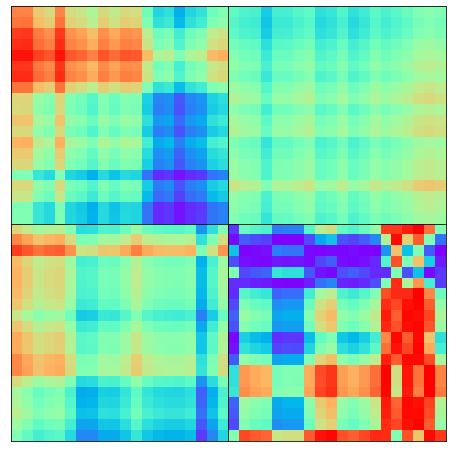

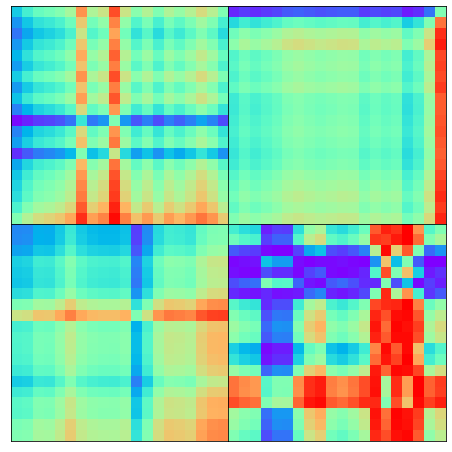

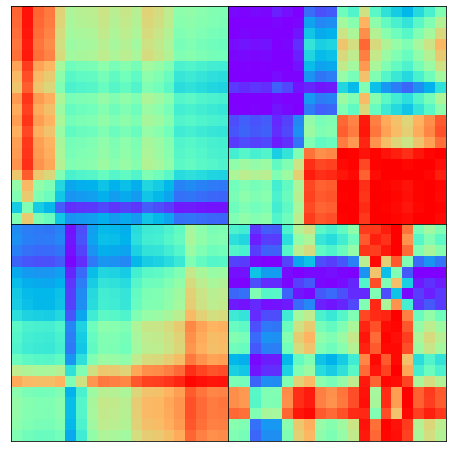

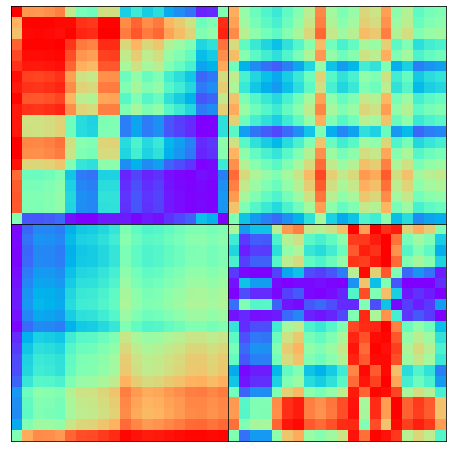

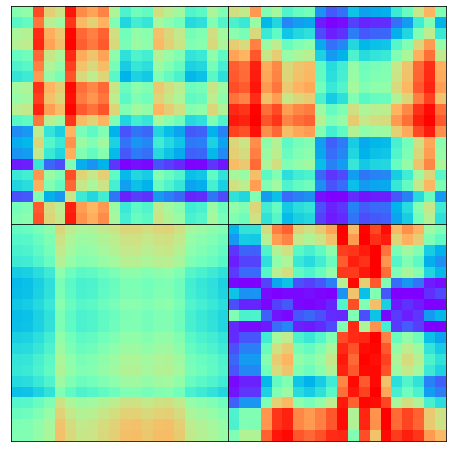

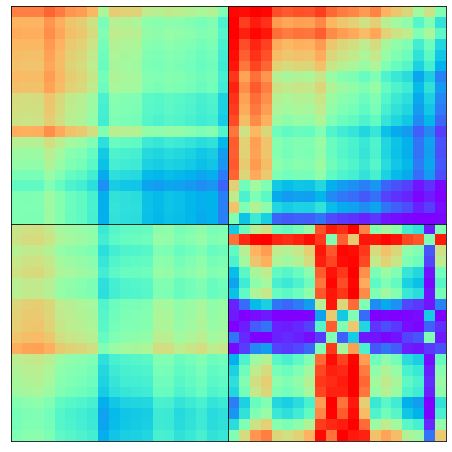

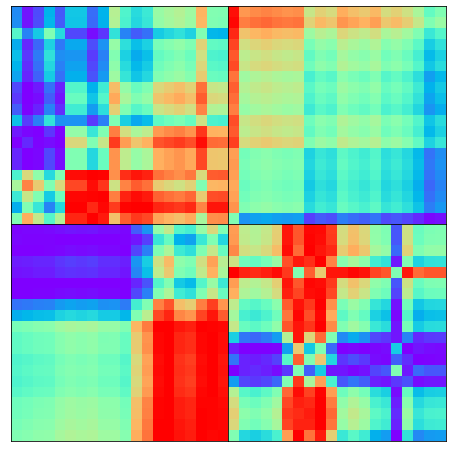

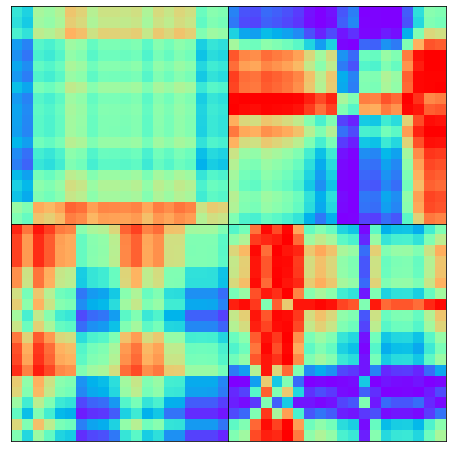

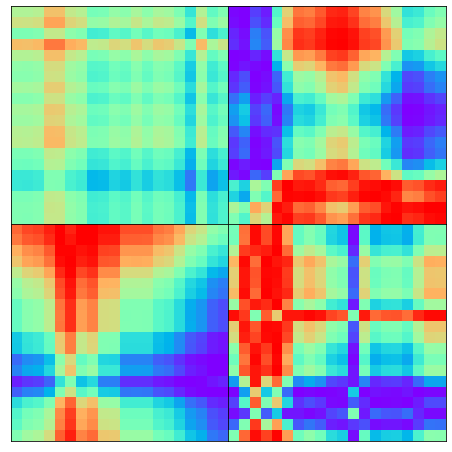

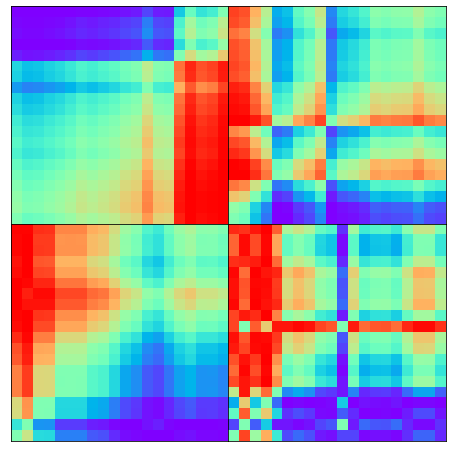

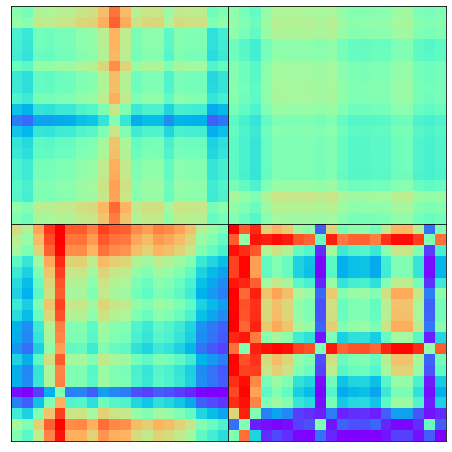

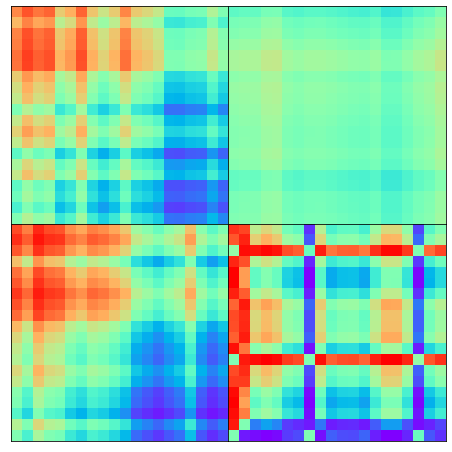

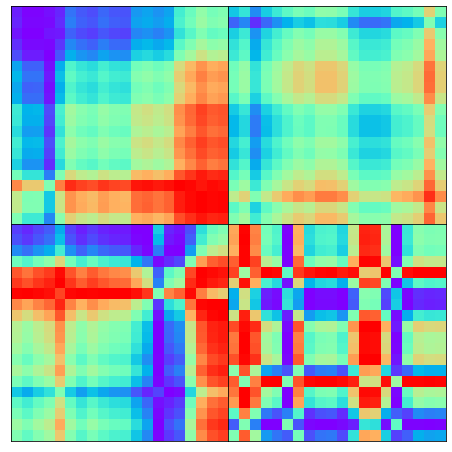

In [10]:
# Drop unnecessary data_slice
df = data.drop(['High', 'Low', 'Volume', 'Open', 'c_ts', 'o_date'], axis=1)
df['DateTime'] = pd.to_datetime(df['o_ts'], unit='ms')
df = df.groupby(pd.Grouper(key='DateTime', freq='1h')).mean().reset_index()     # '1min'
df['Close'] = df['Close'].replace(to_replace=0, method='ffill')

# Send to slicing
decision_map = set_gaf_data(df[:2000]);
generate_gaf(decision_map)

In [9]:
def set_gaf_data(df: pd.DataFrame) -> None:
    """
    :param df: DataFrame data_slice
    :return: None
    """
    dates = df['DateTime'].dt.date
    dates = dates.drop_duplicates()
    list_dates = dates.apply(str).tolist()
    index = 50
    # Container to store data_slice for the creation of GAF
    decision_map = {key: [] for key in ['LONG', 'SHORT']}
    while True:
        if index >= len(list_dates) - 1:
        #if index >= 51:
            break
        # Select appropriate timeframe
        data_slice = df.loc[(df['DateTime'] > list_dates[index - 20]) & (df['DateTime'] < list_dates[index])]
        #print(data_slice)
        gafs = []
        # Group data_slice by time frequency
        for freq in ['1h', '2h', '4h', '1d']:
            group_dt = data_slice.groupby(pd.Grouper(key='DateTime', freq=freq)).mean().reset_index()
            group_dt = group_dt.dropna()
            #print('-->', freq, group_dt)
            #gafs.append(group_dt['Close'].tail(20))
            gafs.append(group_dt['Close'].tail(100))
        # Decide what trading position we should take on that day
        future_value = df[df['DateTime'].dt.date.astype(str) == list_dates[index]]['Close'].iloc[-1]
        current_value = data_slice['Close'].iloc[-1]
        decision = trading_action(future_close=future_value, current_close=current_value)
        decision_map[decision].append([list_dates[index - 1], gafs])
        index += 1
        #print('index:', index)
        
    # Log stuff
    dt_points = dates.shape[0]
    total_short = len(decision_map['SHORT'])
    total_long = len(decision_map['LONG'])
    images_created = total_short + total_long
    print("========PREPROCESS REPORT========:\nTotal Data Points: {0}\nTotal Images Created: {1}"
          "\nTotal LONG positions: {2}\nTotal SHORT positions: {3}".format(dt_points,
                                                                           images_created,
                                                                           total_short,
                                                                           total_long))
    print('1h 2h 4h 1d')
    return decision_map

def trading_action(future_close: int, current_close: int) -> str:
    """
    :param future_close: Integer
    :param current_close: Integer
    :return: Folder destination as String
    """
    current_close = current_close
    future_close = future_close
    if current_close < future_close:
        decision = 'LONG'
    else:
        decision = 'SHORT'
    return decision


def generate_gaf(images_data) -> None:
    """
    :param images_data:
    :return:
    """
    for decision, data in images_data.items():
        for image_data in data:
#             print('image_data[1]:', image_data[1])
            to_plot = [create_gaf(x)['gadf'] for x in image_data[1]]
            #print('to_plot:', to_plot)
#             print('to_plot.size:', to_plot.size)
            create_images(X_plots=to_plot,
                              image_name='{0}'.format(image_data[0].replace('-', '_')),
                              destination=decision)
            #break


# Pass times-eries and create a Gramian Angular Field image
# Grab times-eries and draw the charts
def create_gaf(ts):
    """
    :param ts:
    :return:
    """
#     print('ts.shape[0]:', ts.shape[0])
#     print('ts.shape[0]:', ts.shape)
#     print('pd.DataFrame(ts).shape:', pd.DataFrame(ts).shape)
#     print('create_gaf:', pd.DataFrame(ts))
    data = dict()
    gadf = GramianAngularField(method='difference', image_size=ts.shape[0])
    data['gadf'] = gadf.fit_transform(pd.DataFrame(ts).T)[0]
#     print('data.size:', data['gadf'].size)
    return data


# Create images of the bundle that we pass
def create_images(X_plots, image_name: str, destination: str, image_matrix: tuple =(2, 2)) -> None:
    """
    :param X_plots:
    :param image_name:
    :param destination:
    :param image_matrix:
    :return:
    """
    fig = plt.figure(figsize=[img * 4 for img in image_matrix])
    grid = ImageGrid(fig,
                     111,
                     axes_pad=0,
                     nrows_ncols=image_matrix,
                     share_all=True,
                     )
    images = X_plots
    for image, ax in zip(images, grid):
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(image, cmap='rainbow', origin='lower')

#     repo = os.path.join('GramianAngularFields/TRAIN', destination)
#     fig.savefig(os.path.join(repo, image_name))
#     plt.close(fig)
    fig